In [1]:
import sys

sys.path.append("../")
from hamilton_neural_network import (
    TrainTestData,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import NegLogIndepedentGaussians, NegLogThreeDimRosenbrock
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling

tf.random.set_seed(0)

2.18.0


In [2]:
U = NegLogThreeDimRosenbrock()
K = NegLogIndepedentGaussians(
    tf.constant([0.0, 0.0, 0.0]), tf.constant([1.0, 1.0, 1.0])
)
q0 = tf.constant([[0.0, 0.0, 0.0]])
p0 = tf.random.normal(q0.shape)
T = 100.0
leap_frog_per_unit = 40
num_samples = 40
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

In [3]:
train_test_data = TrainTestData(num_samples, T, leap_frog_per_unit, q0, p0, U=U, K=K)
samples = train_test_data()
tf.io.write_file("../exps/demo2_train_test_data.txt", tf.io.serialize_tensor(samples))

Generating samples...
Finished generating samples.


In [4]:
file = tf.io.read_file("../exps/demo2_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_test_data = tf.random.shuffle(train_test_data)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
lhnn = LatentHamiltonianNeuralNetwork(3, 64, 3)
lhnn.build(input_shape=(1, 6))
train_hist, test_hist = lhnn.train(
    5000,
    1000,
    4e-5,
    train_data,
    test_data,
    save_dir="../exps/demo2_lhnn.weights.h5",
    print_every=500,
)

Training started...
Epoch 0: Train loss 99.91273498535156, Test loss 98.72189331054688.
Epoch 500: Train loss 0.07291653752326965, Test loss 0.07772736251354218.
Epoch 1000: Train loss 0.022857585921883583, Test loss 0.023299993947148323.
Epoch 1500: Train loss 0.013457905501127243, Test loss 0.013674571178853512.
Epoch 2000: Train loss 0.009549959562718868, Test loss 0.009790700860321522.
Epoch 2500: Train loss 0.007592242211103439, Test loss 0.00775939179584384.
Epoch 3000: Train loss 0.0065465644001960754, Test loss 0.006749222055077553.
Epoch 3500: Train loss 0.005729676689952612, Test loss 0.008882740512490273.
Epoch 4000: Train loss 0.004459691233932972, Test loss 0.006533361971378326.
Epoch 4500: Train loss 0.0049147289246320724, Test loss 0.007041740696877241.
Training complete!


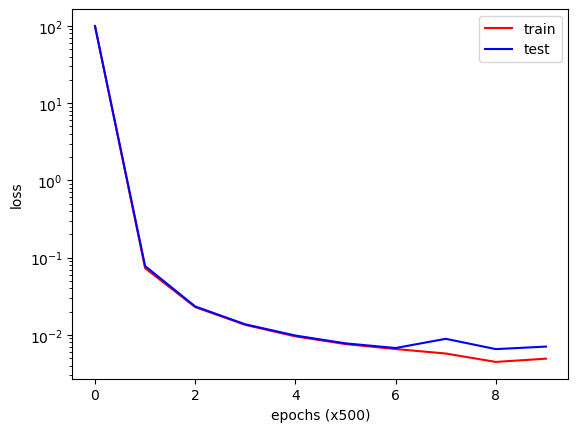

In [5]:
ax, fig = plt.subplots()
fig.plot(train_hist, label="train", color="red")
fig.plot(test_hist, label="test", color="blue")
fig.legend()
fig.set_yscale("log")
fig.set_xlabel("epochs (x500)")
fig.set_ylabel("loss")
plt.show()

In [ ]:
lhnn = LatentHamiltonianNeuralNetwork(3, 64, 3)
lhnn.build(input_shape=(1, 6))
lhnn.load_weights("../exps/demo2_lhnn.weights.h5")
q0 = tf.constant([[0.0, 0.0, 0.0]])
nuts = NoUTurnSampling(
    num_samples=125000,
    q0=q0,
    dt=0.05,
    lhnn=lhnn,
    Hamiltonian=HamiltonianSystem(U=U, K=K),
    Delta_lf=1000.0,
    Delta_lhnn=10.0,
    num_lf_steps=20,
    j_max=12,
)
nuts(print_every=5000)
q_hist = tf.concat(nuts.q_hist, axis=0)
tf.io.write_file("../exps/demo2_q_hist.txt", tf.io.serialize_tensor(q_hist))
# plt.hist(q_hist.numpy()[5000:, 0].flatten(), bins=30, color="blue")
# plt.show()

Sample 0 of 125000
Sample 5000 of 125000
Sample 10000 of 125000
Sample 15000 of 125000
Sample 20000 of 125000
